# 特征选择

## 计算特征之间的相关系数

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import feather
import shutil
%matplotlib inline

In [2]:
data_path = "/home/liuhaozhe/SourceCode/PycharmProjects/User_churn_alert-main/data"
img_path = "/home/liuhaozhe/SourceCode/PycharmProjects/User_churn_alert-main/img"
os.chdir(data_path)
if os.path.exists(img_path):
    shutil.rmtree(img_path)
    os.mkdir(img_path)

In [3]:
X_train = feather.read_dataframe("X_train_cleaned.feather")
X_test = feather.read_dataframe("X_test_cleaned.feather")
y_train = feather.read_dataframe("y_train_cleaned.feather")
y_test = feather.read_dataframe("y_test_cleaned.feather")
X_train.shape, X_test.shape

((755155, 226), (323639, 226))

In [4]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [5]:
def plot_corr(corr_, fig_name):
    fig, ax = plt.subplots()
    fig.set_size_inches(30, 30)
    sns.heatmap(corr_, vmin=0, vmax=1)
    plt. savefig(os.path.join(img_path, f"{fig_name}.png"), dpi=300)

## 检查所有特征与目标标签的相关系数

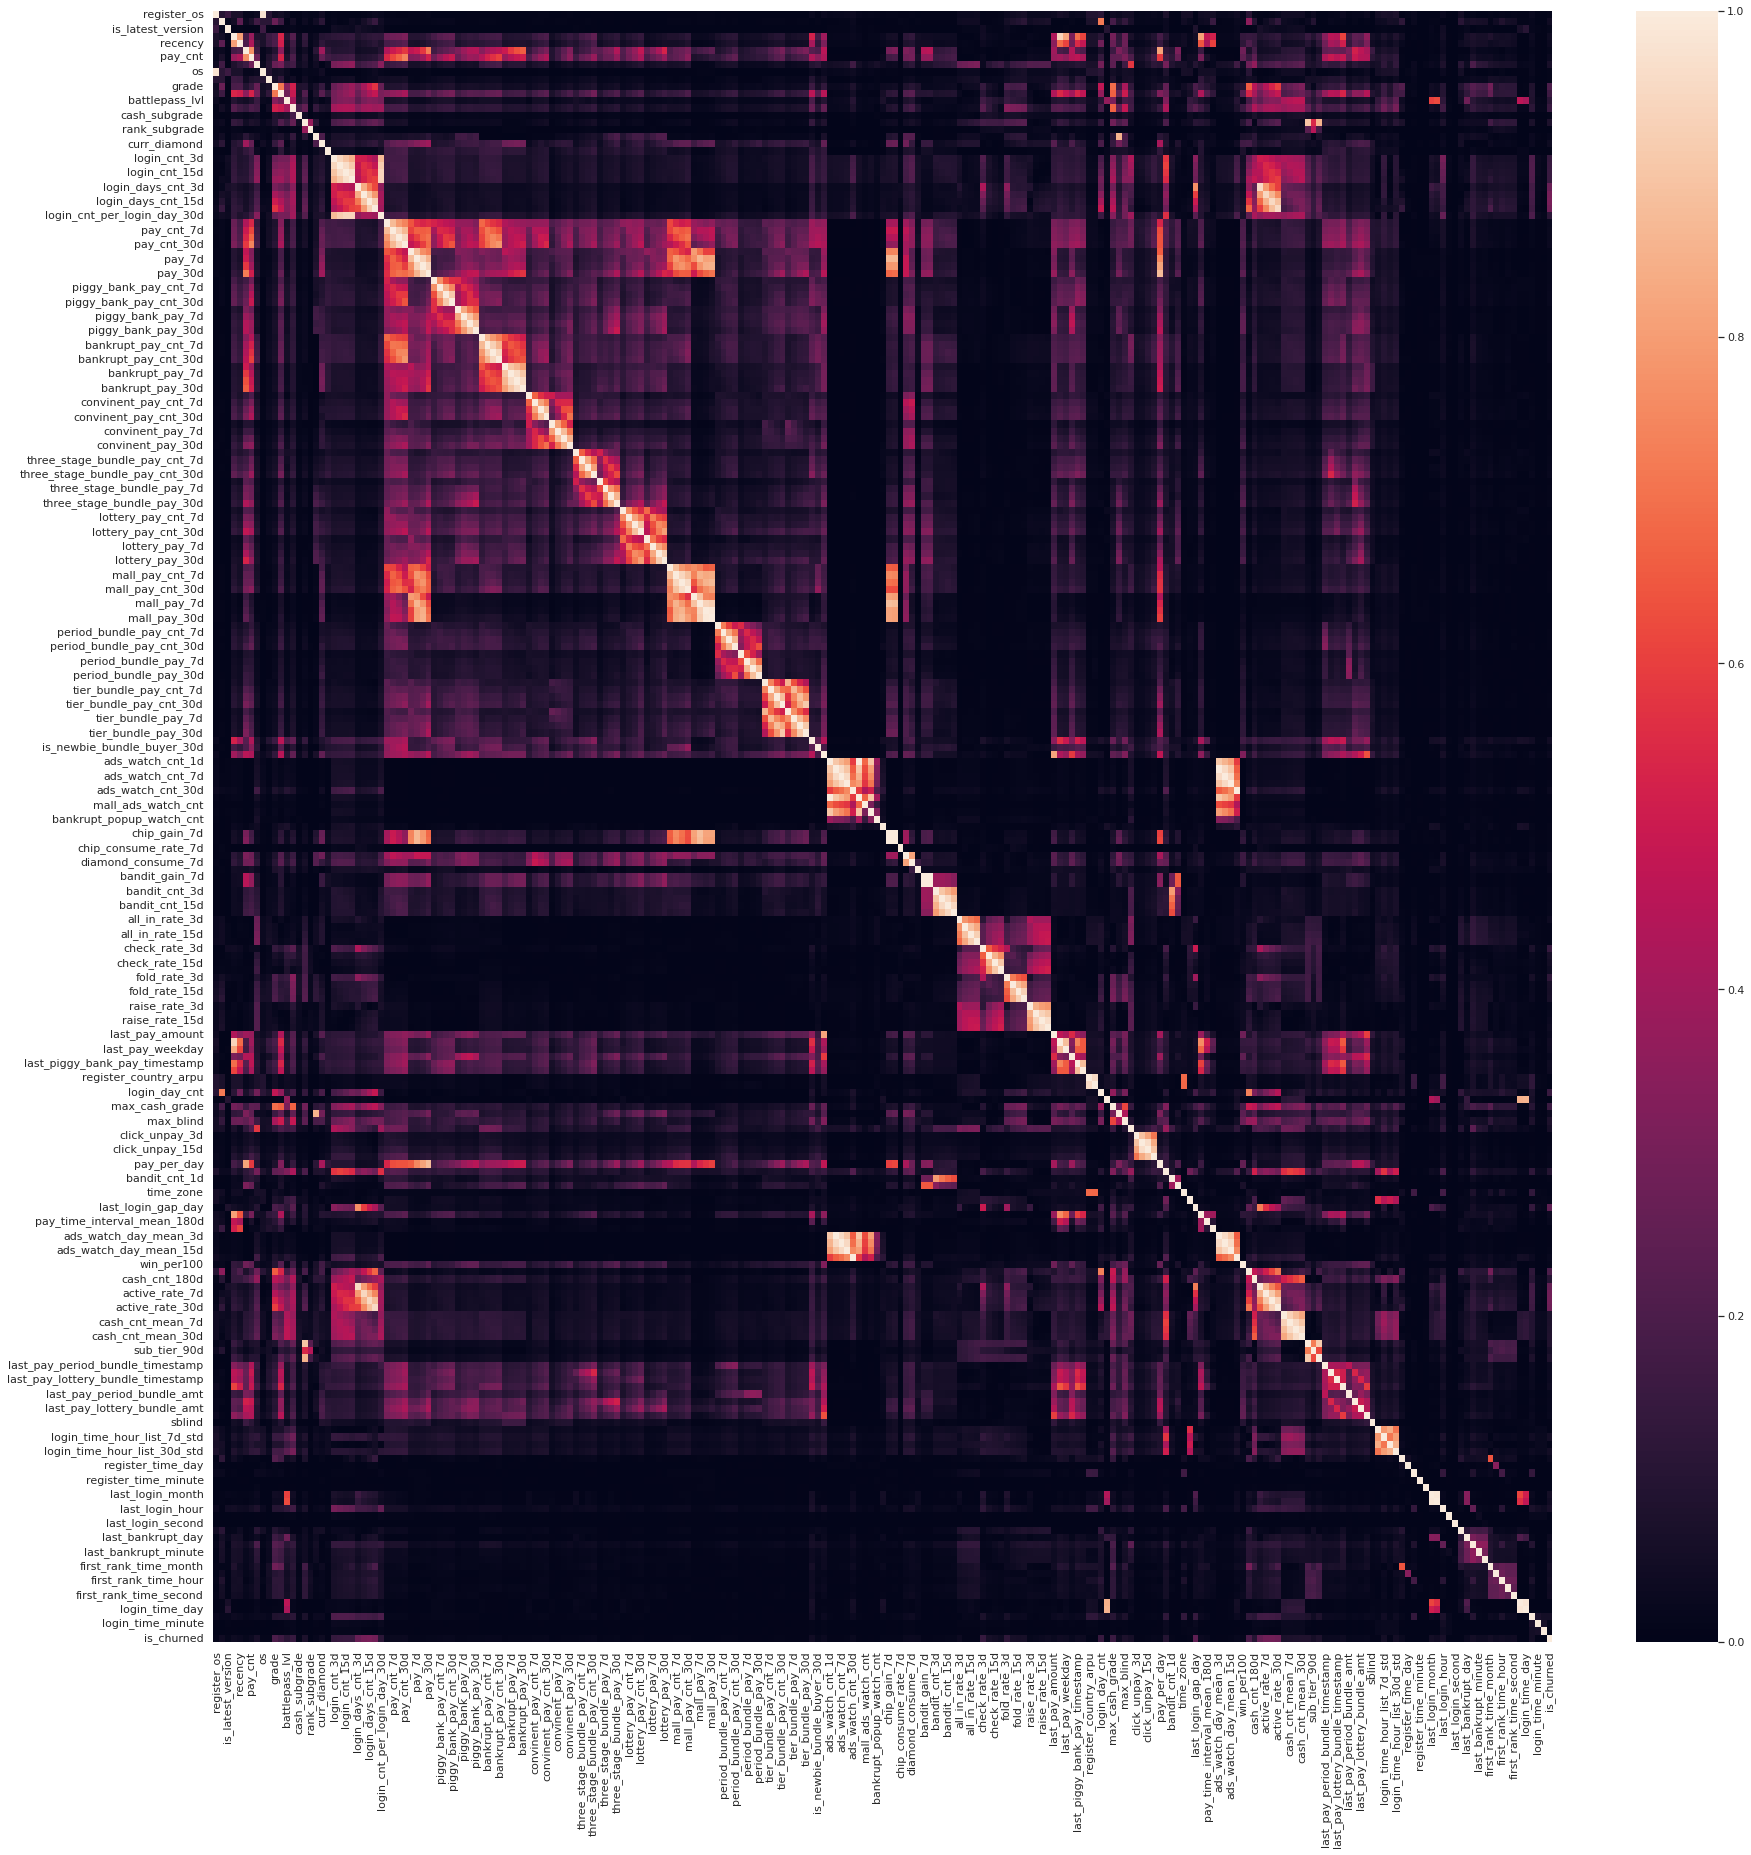

In [6]:
corr_with_target = pd.concat([X_train, y_train], axis=1).corr().abs()
plot_corr(corr_with_target, "corr_with_target")

In [7]:
corr_with_target[["is_churned"]].sort_values(by="is_churned", ascending=False)

,is_churned
is_churned,1.000000
login_days_cnt_15d,0.306305
login_days_cnt_7d,0.300615
login_days_cnt_30d,0.291611
active_rate_15d,0.291283
...,...
last_bankrupt_month,0.001053
time_zone,0.000976
register_time_second,0.000934
register_time_hour,0.000465


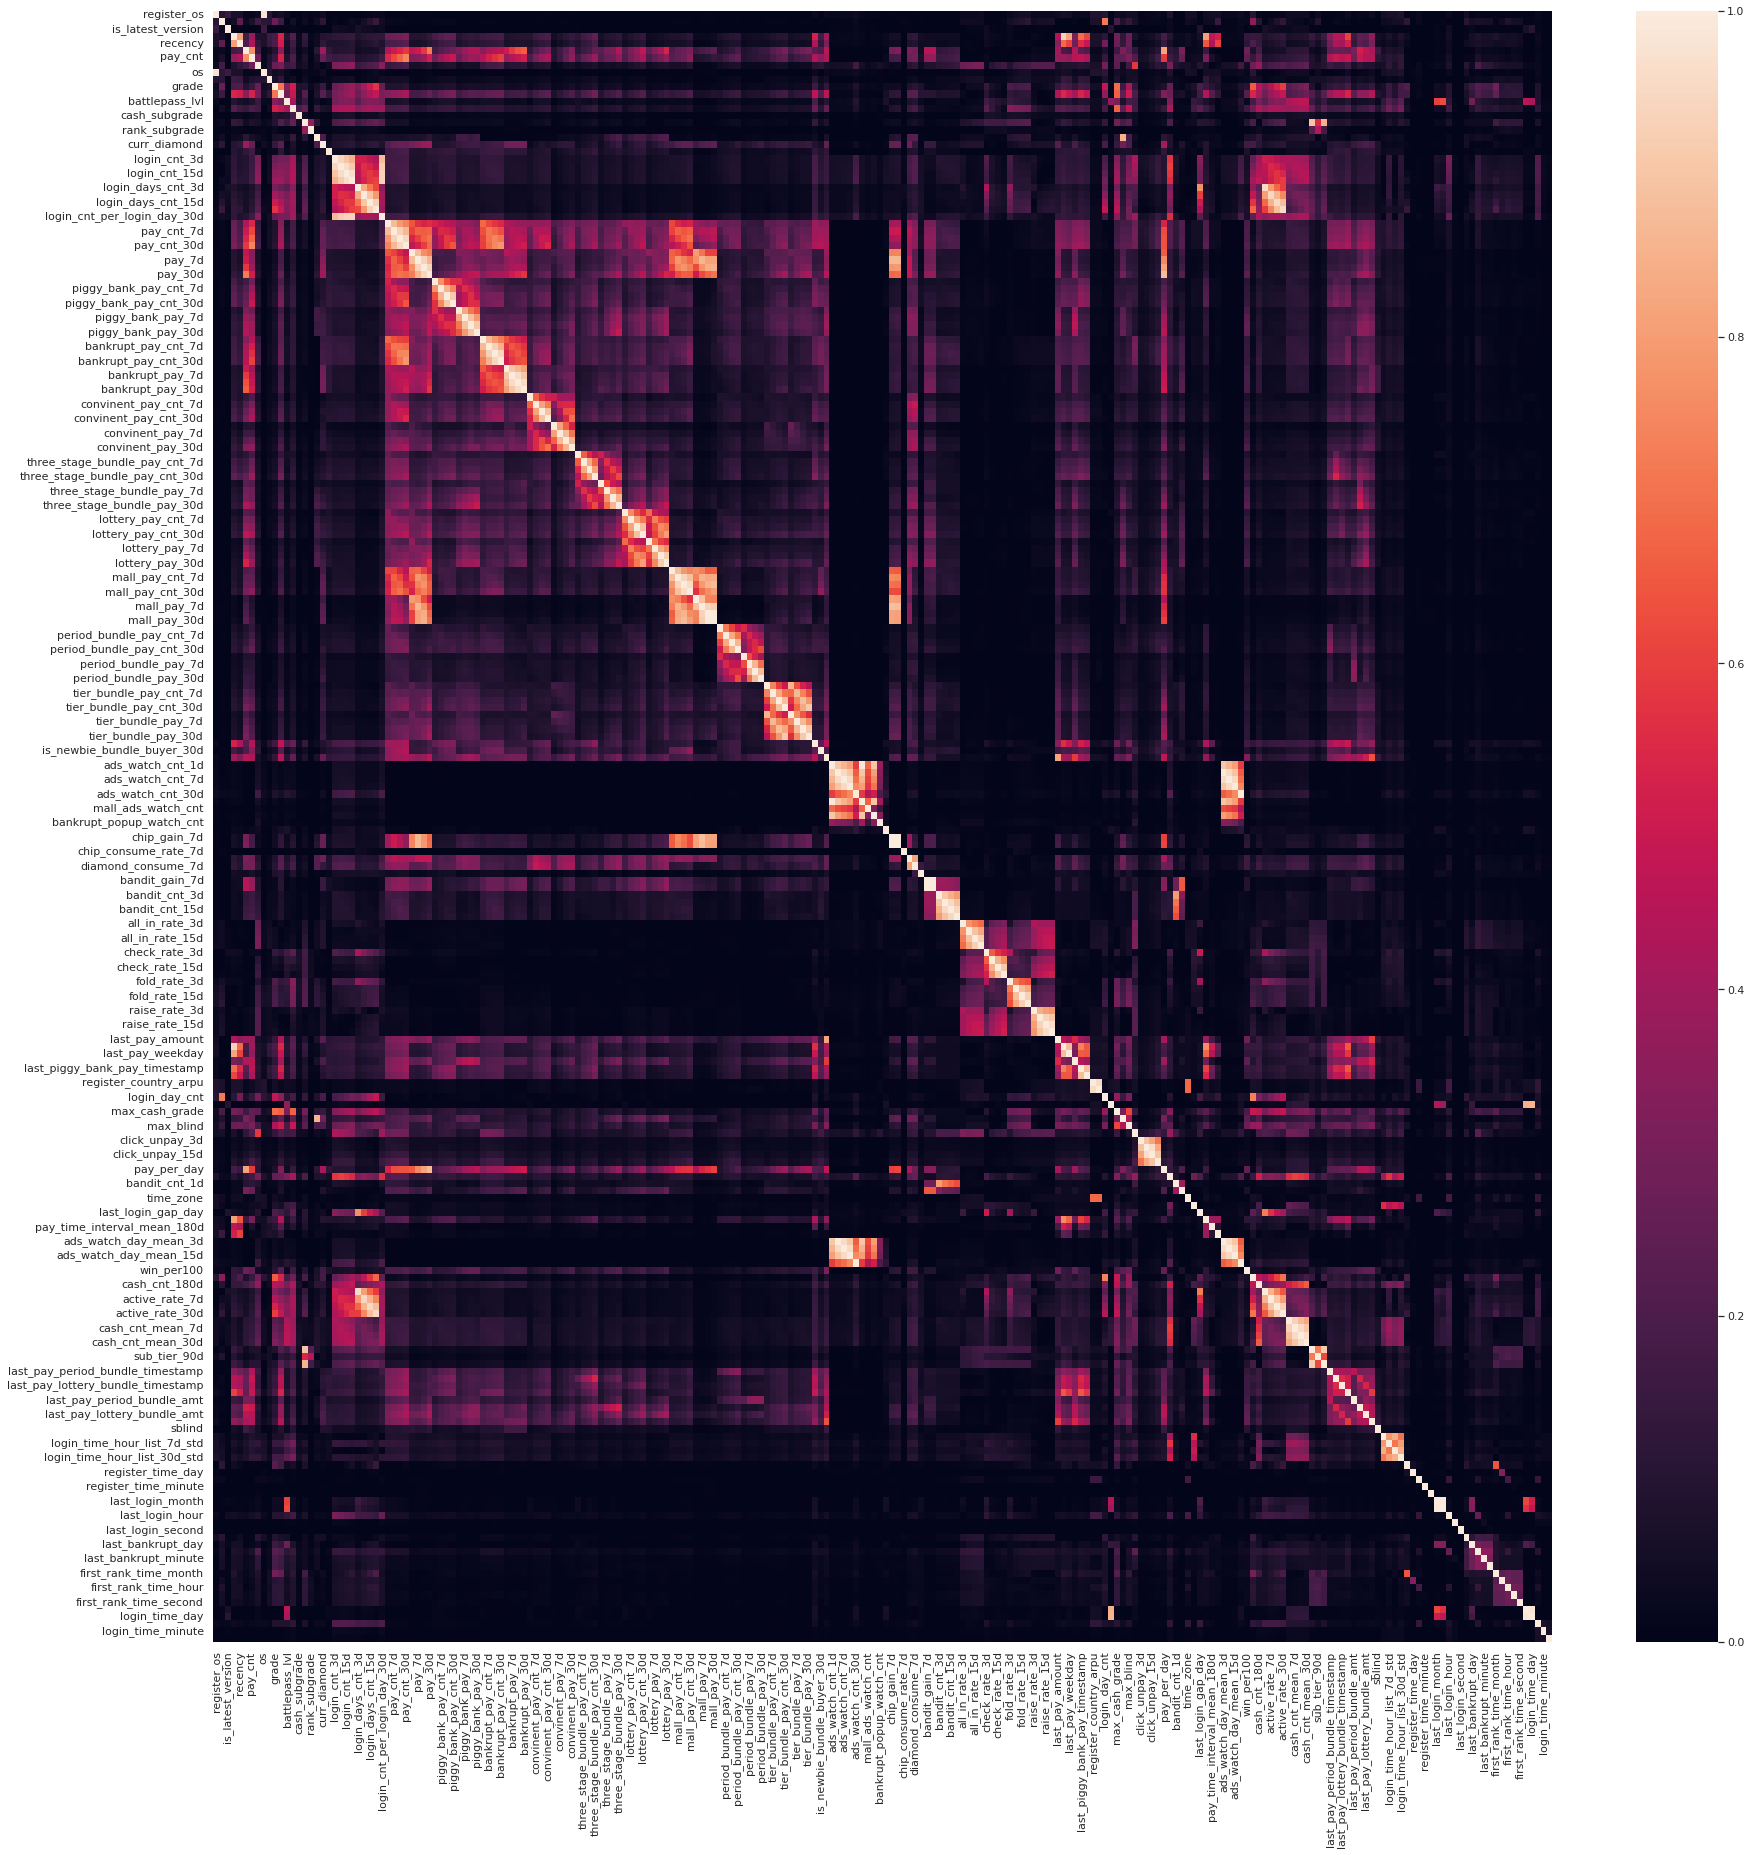

In [8]:
corr = X_train.corr().abs()
plot_corr(corr, "corr_all")

In [9]:
corr_all = corr.copy()

# 相关系数与随机森林分类的混合方法

将特征分为内部相关的几个特征群体，再对每个特征群体使用随机森林分类，得到一个特征群体中所有特征的重要性，并筛选丢弃重要性低的特征，并且将上述过程不断迭代，选择不超过120个特征。再将120个特征送入随机森林分类器。进行最终的特征筛选。

In [10]:
corr = corr.unstack()
corr = corr.sort_values(ascending=False)
corr = pd.DataFrame(corr).reset_index()
corr.columns = ['feat1', 'feat2', 'corr']

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from itertools import compress

In [12]:
dropped_feats = []  # 丢弃的特征，每个loop会不断增加
selected_feats = list(X_train.columns)  # 被选择的特征，每个loop会不断减少
thres = 0.95

In [13]:
while True:
    corr_temp = corr.copy()
    corr_temp = corr_temp[corr_temp["corr"] < 1]
    corr_temp = corr_temp[corr_temp["corr"] >= thres]
    
    grouped_feats = []  # buffer
    corr_groups = []  # buffer

    i = 0  # 作为存储heatmap的图片名字

    for feat in corr_temp.feat1.unique():
        if feat not in grouped_feats:
            i += 1
            corr_block = corr_temp[(corr_temp.feat1 == feat)]

            # 绘制一个特征群体内，不同特征之间的相关系数heatmap
    #         plot_corr(corr_all.loc[list(corr_block.feat2.unique()) + [feat], list(corr_block.feat2.unique()) + [feat]].abs(), f"lvl1_{i}")
            grouped_feats += list(corr_block.feat2.unique()) + [feat]  # 累加已经属于某个特征相关群体的特征 

            corr_groups.append(corr_block)  # 增加该特征群体，用于后续使用随机森林分类，对该群体的特征进行筛选


    for group in corr_groups:
        feats = list(group.feat1.unique()) + list(group.feat2.unique())
    #     print(f"最初的特征：{feats}")
        rfc_sel = SelectFromModel(RandomForestClassifier(n_estimators=20, random_state=1, max_depth=4))
        rfc_sel.fit(X_train[feats], y_train.values.ravel())

        rfc_sel_support = np.array(rfc_sel.get_support())  # 得到特征筛选的bool序列
        dropped_feats += list(compress(feats, ~rfc_sel_support))  # 增加丢弃的特征
    #     print(f"筛选的特征：{list(compress(feats, rfc_sel_support))}")
    
    dropped_feats = list(set(dropped_feats))  # 去掉重复的特征
    selected_feats = [i for i in selected_feats if i not in dropped_feats]  # selected_feats中去掉丢弃的特征

    # 更新corr，过滤掉被丢弃特征的所有相关系数
    corr = corr[corr["feat1"].isin(selected_feats) & corr["feat2"].isin(selected_feats)]

    thres *= 0.995
    print(f"被选择的特征个数为{len(selected_feats)}, 被丢弃的特征个数为{len(dropped_feats)}")
    if len(selected_feats) <= 175:
        break

被选择的特征个数为201, 被丢弃的特征个数为25
被选择的特征个数为197, 被丢弃的特征个数为29
被选择的特征个数为194, 被丢弃的特征个数为32
被选择的特征个数为192, 被丢弃的特征个数为34
被选择的特征个数为189, 被丢弃的特征个数为37
被选择的特征个数为187, 被丢弃的特征个数为39
被选择的特征个数为186, 被丢弃的特征个数为40
被选择的特征个数为184, 被丢弃的特征个数为42
被选择的特征个数为182, 被丢弃的特征个数为44
被选择的特征个数为179, 被丢弃的特征个数为47
被选择的特征个数为177, 被丢弃的特征个数为49
被选择的特征个数为175, 被丢弃的特征个数为51


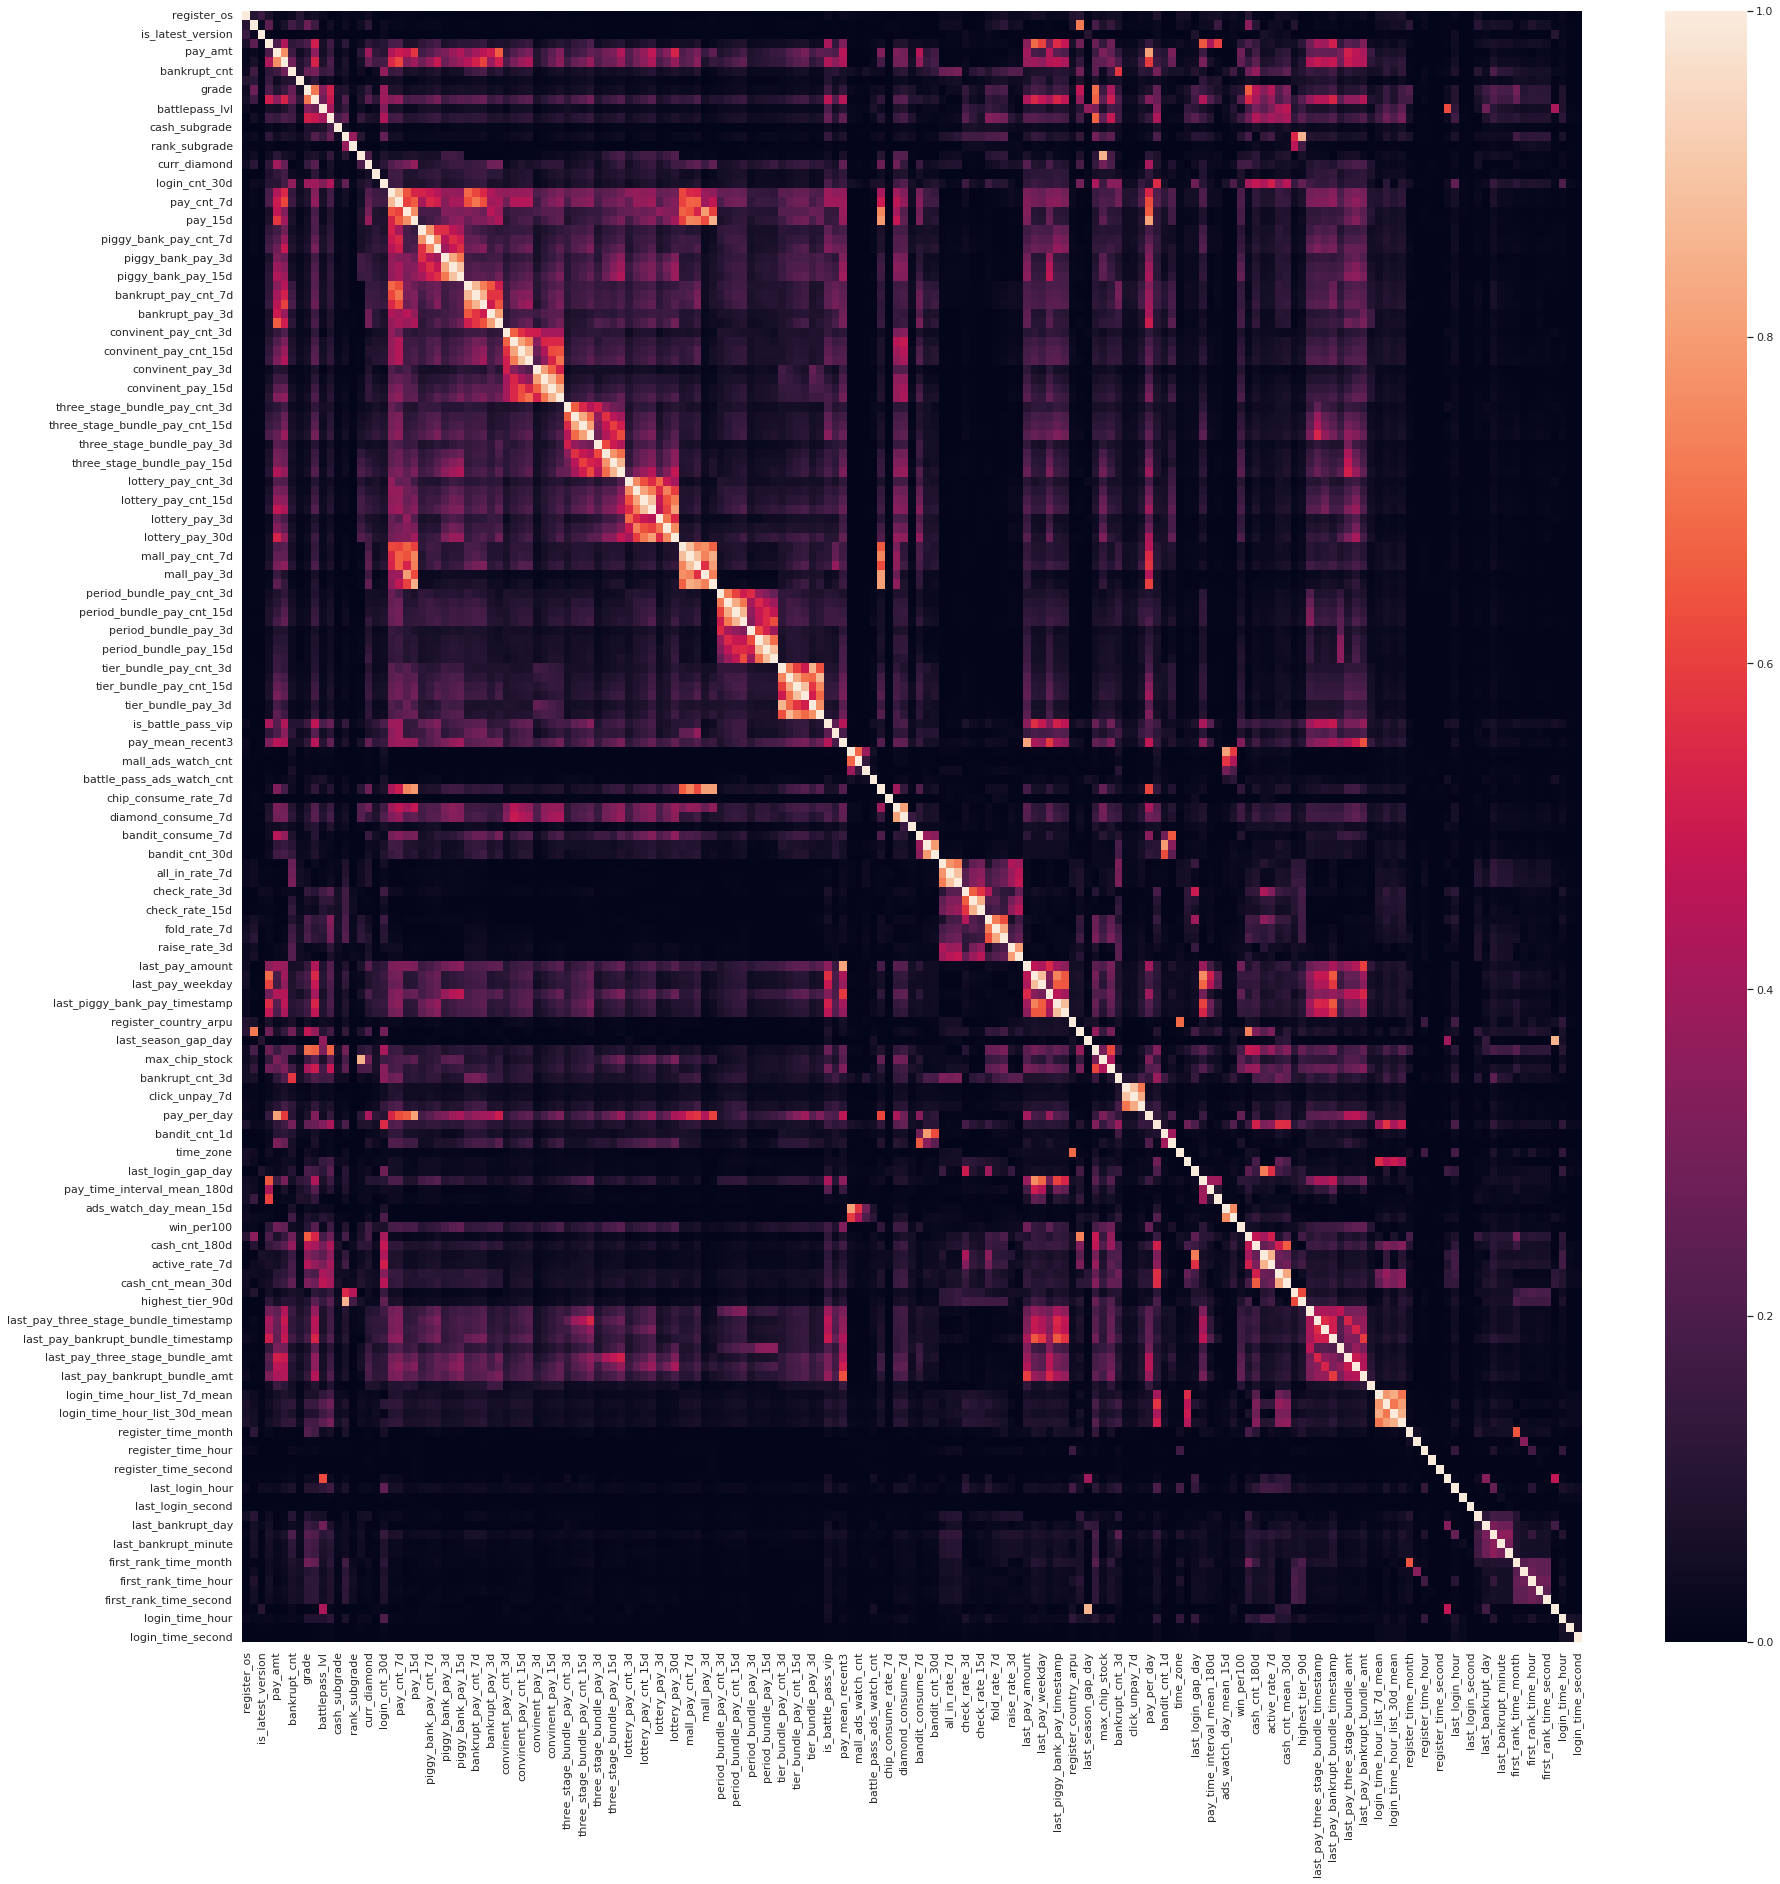

In [14]:
plot_corr(corr_all.loc[selected_feats, selected_feats], f"selected_feats")

In [15]:
rfc = RandomForestClassifier(n_estimators=100, random_state=34, max_depth=10)
rfc.fit(X_train[selected_feats], y_train.values.ravel())


importance = pd.concat([pd.Series(selected_feats), pd.Series(rfc.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance = importance.sort_values(by='importance', ascending=False)

Text(0, 0.5, 'importance')

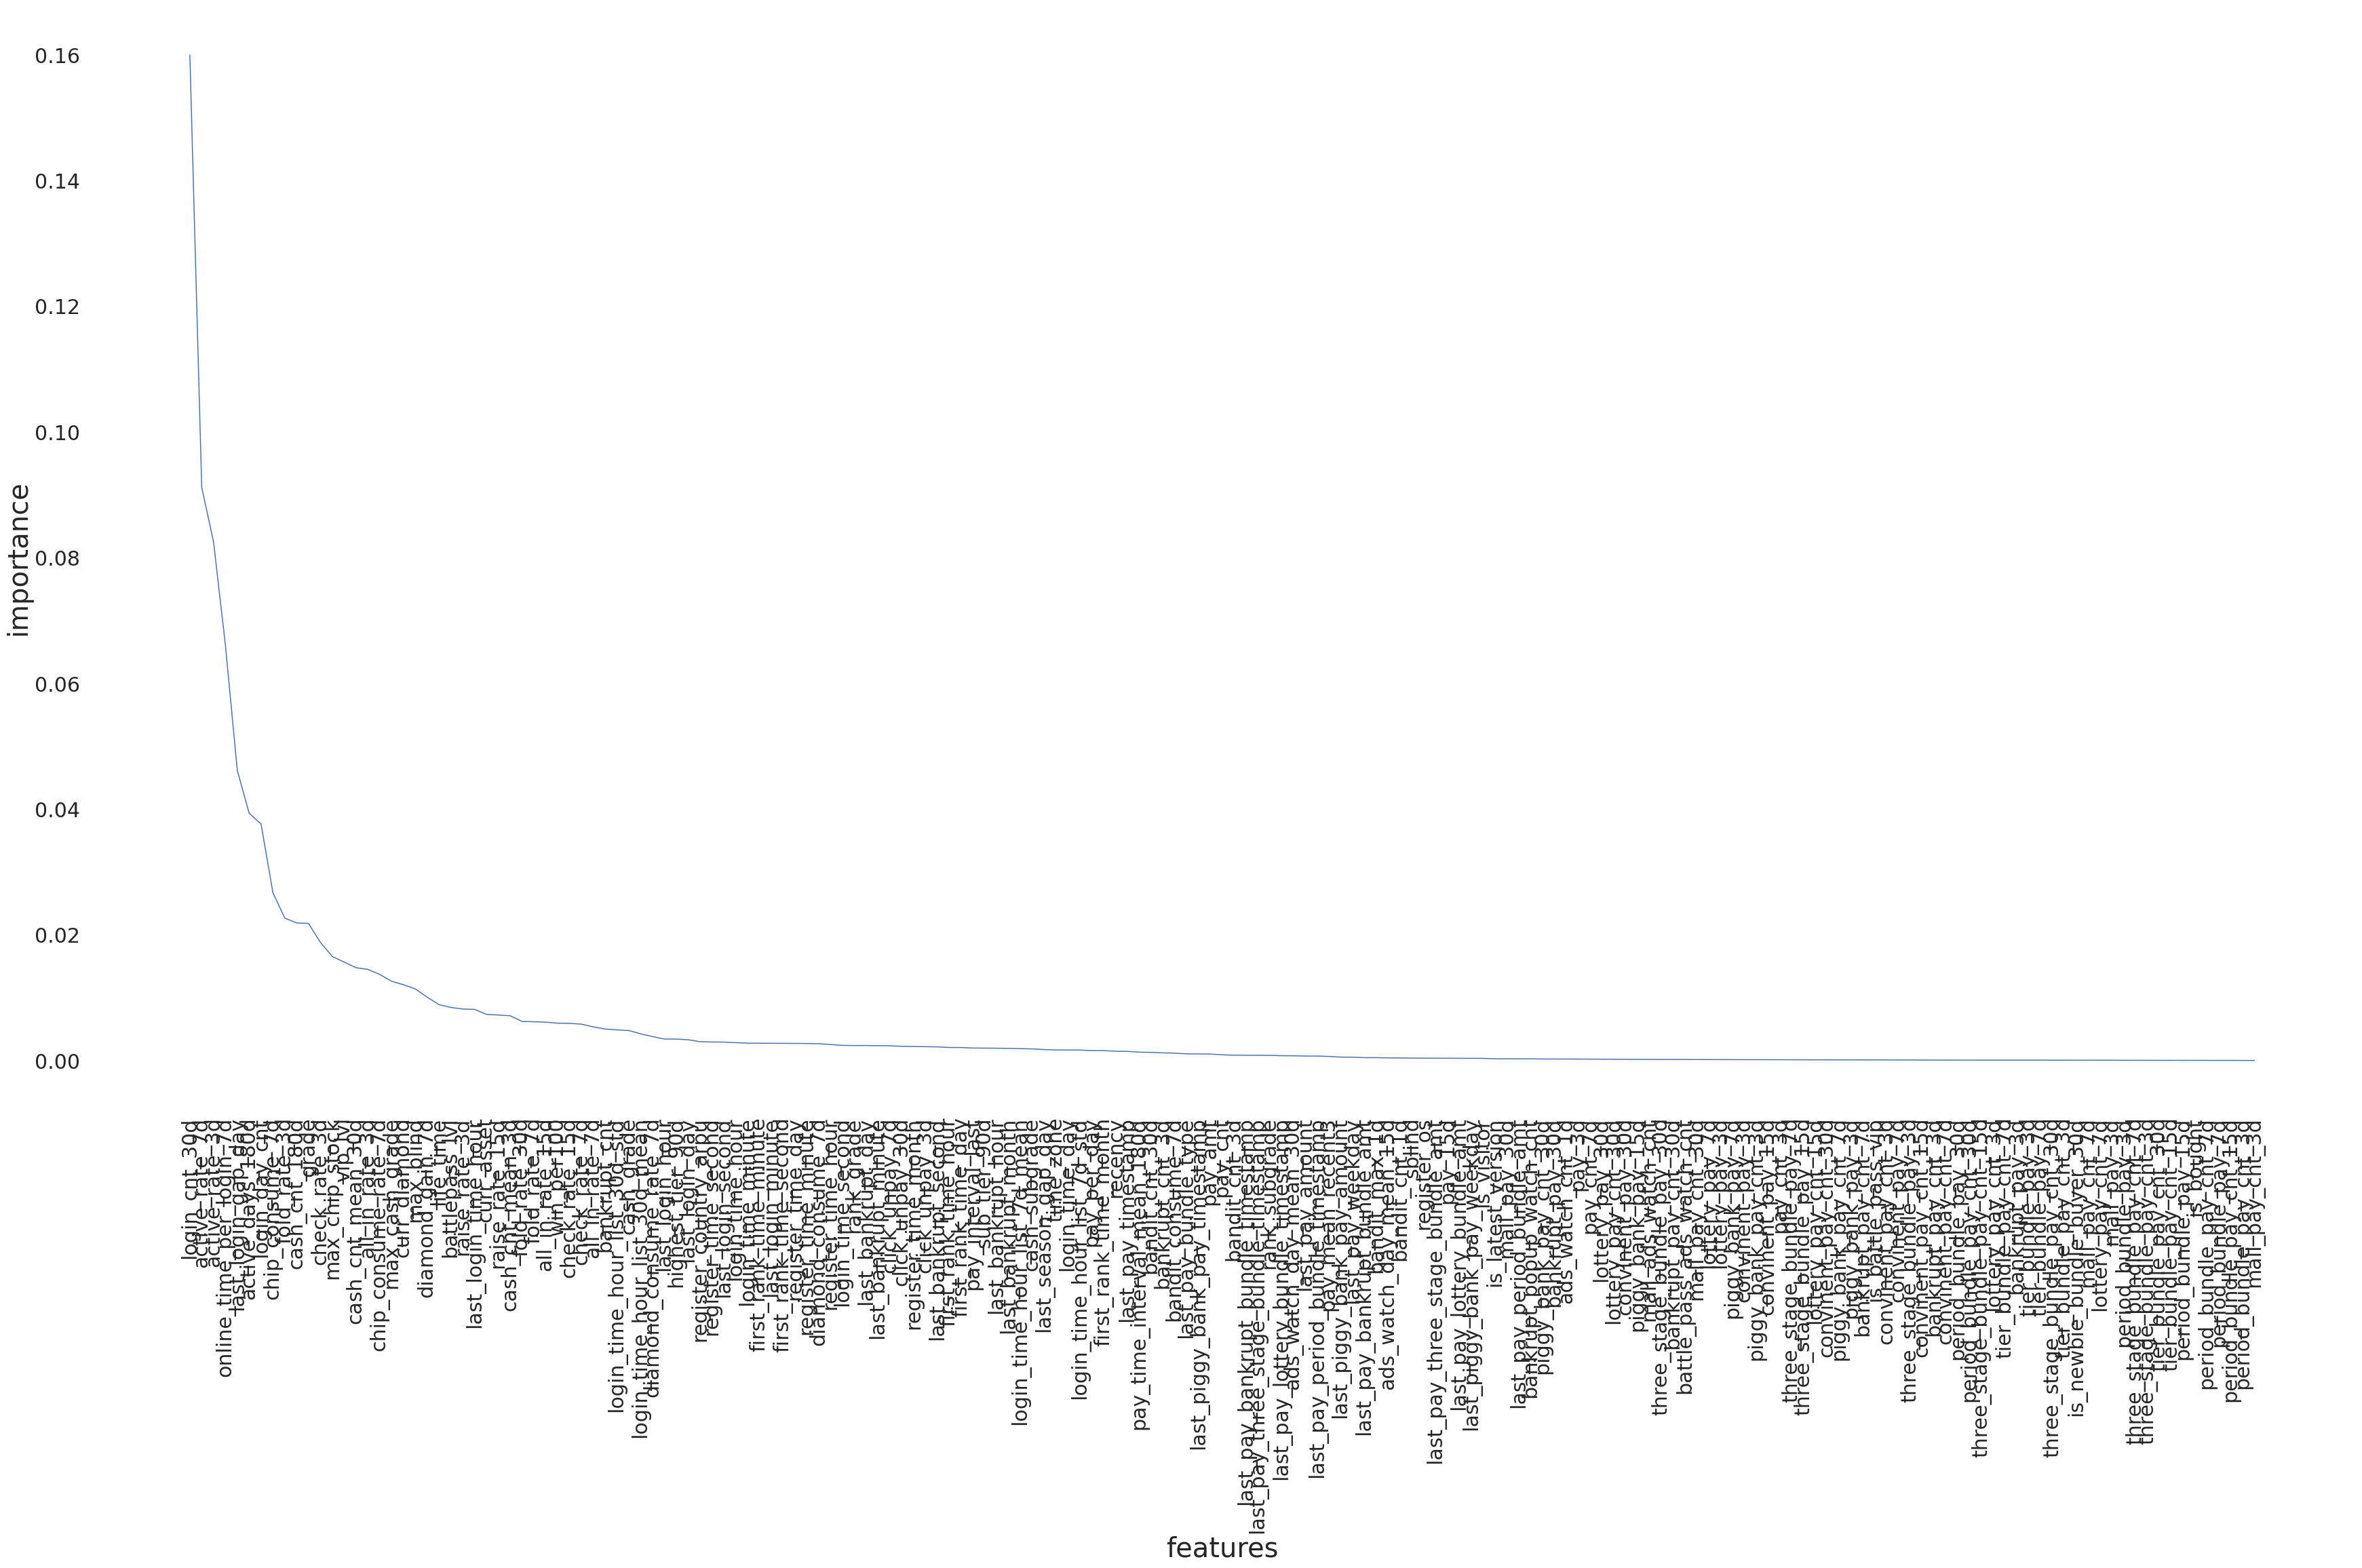

In [16]:
plt.figure(figsize=(60, 30))
sns.lineplot(x=importance["feature"], y=importance["importance"], data=importance)
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel(xlabel="features", fontsize=40)
plt.ylabel(ylabel="importance", fontsize=40)
# plt.savefig(os.path.join(img_path, f"importance.png"), dpi=300)

In [17]:
final_selected_feats = list(importance["feature"])[: 32]

## 使用随机森林算法进行最终的性能评估

In [34]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=8)
    rf.fit(X_train, y_train)
    print('Train set')
    pred = rf.predict(X_train)
    pred_prob = rf.predict_proba(X_train)
    print('Random Forests precision_score: {}'.format(precision_score(y_train, pred)))
    print('Random Forests recall_score: {}'.format(recall_score(y_train, pred)))
    print('Random Forests f1_score: {}'.format(f1_score(y_train, pred)))
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred_prob[:,1])))
    print('Test set')
    pred = rf.predict(X_test)
    pred_prob = rf.predict_proba(X_test)
    print('Random Forests precision_score: {}'.format(precision_score(y_test, pred)))
    print('Random Forests recall_score: {}'.format(recall_score(y_test, pred)))
    print('Random Forests f1_score: {}'.format(f1_score(y_test, pred)))
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred_prob[:,1])))

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [36]:
run_randomForests(X_train, X_test, y_train.values.ravel(), y_test.values.ravel())

Train set
Random Forests precision_score: 0.8
Random Forests recall_score: 0.001884443247972541
Random Forests f1_score: 0.003760029543089267
Random Forests roc-auc: 0.8969340992328978
Test set
Random Forests precision_score: 0.5
Random Forests recall_score: 0.0011695906432748538
Random Forests f1_score: 0.0023337222870478415
Random Forests roc-auc: 0.8893833787959231


In [37]:
run_randomForests(X_train[final_selected_feats], X_test[final_selected_feats], y_train.values.ravel(), y_test.values.ravel())

Train set
Random Forests precision_score: 0.7541899441340782
Random Forests recall_score: 0.004542854258505233
Random Forests f1_score: 0.009031308536259032
Random Forests roc-auc: 0.8951737602490903
Test set
Random Forests precision_score: 0.5747126436781609
Random Forests recall_score: 0.003898635477582846
Random Forests f1_score: 0.007744733581164807
Random Forests roc-auc: 0.8871920468508578


In [38]:
final_selected_feats

['login_cnt_30d',
 'active_rate_7d',
 'active_rate_3d',
 'online_time_per_login_7d',
 'last_login_gap_day',
 'active_days_180d',
 'login_day_cnt',
 'chip_consume_7d',
 'fold_rate_3d',
 'cash_cnt_180d',
 'grade',
 'check_rate_3d',
 'max_chip_stock',
 'vip_lvl',
 'cash_cnt_mean_30d',
 'all_in_rate_3d',
 'chip_consume_rate_7d',
 'max_cash_grade',
 'curr_diamond',
 'max_blind',
 'diamond_gain_7d',
 'life_time',
 'battlepass_lvl',
 'raise_rate_3d',
 'last_login_time_hour',
 'curr_asset',
 'raise_rate_15d',
 'cash_cnt_mean_3d',
 'fold_rate_30d',
 'fold_rate_7d',
 'all_in_rate_15d',
 'win_per100']

## 直接使用随机森林分类

In [39]:
rfc = RandomForestClassifier(n_estimators=100, random_state=34, max_depth=10)
rfc.fit(X_train, y_train.values.ravel())


importance = pd.concat([pd.Series(list(X_train.columns)), pd.Series(rfc.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance = importance.sort_values(by='importance', ascending=False)

In [40]:
final_selected_feats_1 = list(importance["feature"])[: 32]

In [41]:
run_randomForests(X_train[final_selected_feats_1], X_test[final_selected_feats_1], y_train.values.ravel(), y_test.values.ravel())

Train set
Random Forests precision_score: 0.6652267818574514
Random Forests recall_score: 0.010364437863848976
Random Forests f1_score: 0.02041086812458582
Random Forests roc-auc: 0.896787332796813
Test set
Random Forests precision_score: 0.585635359116022
Random Forests recall_score: 0.008265107212475633
Random Forests f1_score: 0.016300169152698753
Random Forests roc-auc: 0.8896221175683932


In [42]:
final_selected_feats_1

['login_cnt_15d',
 'login_days_cnt_15d',
 'login_cnt_30d',
 'login_days_cnt_7d',
 'login_days_cnt_30d',
 'active_rate_15d',
 'active_rate_30d',
 'login_cnt_7d',
 'active_rate_7d',
 'login_days_cnt_3d',
 'online_time_per_login_7d',
 'login_cnt_3d',
 'login_cnt_per_login_day_30d',
 'active_days_180d',
 'active_rate_3d',
 'chip_gain_7d',
 'login_day_cnt',
 'last_login_gap_day',
 'check_rate_3d',
 'chip_consume_7d',
 'max_chip_stock',
 'cash_cnt_180d',
 'fold_rate_3d',
 'all_in_rate_3d',
 'chip_consume_rate_7d',
 'cash_cnt_mean_30d',
 'grade',
 'curr_diamond',
 'vip_lvl',
 'cash_cnt_mean_15d',
 'life_time',
 'max_blind']

## 直接使用相关系数

In [43]:
corr_with_target_sorted = corr_with_target[["is_churned"]].sort_values(by="is_churned", ascending=False)
corr_with_target_sorted = corr_with_target_sorted.reset_index()
final_selected_feats_2 = list(corr_with_target_sorted["index"])[1: 33]

In [44]:
final_selected_feats_2

['login_days_cnt_15d',
 'login_days_cnt_7d',
 'login_days_cnt_30d',
 'active_rate_15d',
 'active_rate_7d',
 'active_rate_30d',
 'login_days_cnt_3d',
 'active_rate_3d',
 'last_login_gap_day',
 'active_days_180d',
 'grade',
 'vip_lvl',
 'max_cash_grade',
 'login_cnt_30d',
 'login_cnt_15d',
 'login_cnt_7d',
 'login_day_cnt',
 'cash_grade',
 'check_rate_3d',
 'login_cnt_3d',
 'fold_rate_3d',
 'login_cnt_per_login_day_30d',
 'battlepass_lvl',
 'cash_cnt_180d',
 'online_time_per_login_7d',
 'cash_cnt_mean_30d',
 'tier_90d',
 'highest_tier_90d',
 'cash_cnt_mean_15d',
 'max_blind',
 'cash_cnt_mean_7d',
 'rank_grade']

In [45]:
run_randomForests(X_train[final_selected_feats_2], X_test[final_selected_feats_2], y_train.values.ravel(), y_test.values.ravel())

Train set
Random Forests precision_score: 0.6460176991150443
Random Forests recall_score: 0.007369519130464044
Random Forests f1_score: 0.014572797444769763
Random Forests roc-auc: 0.8959890788128783
Test set
Random Forests precision_score: 0.5789473684210527
Random Forests recall_score: 0.005146198830409357
Random Forests f1_score: 0.01020171574310225
Random Forests roc-auc: 0.8896095318648356
